<a href="https://colab.research.google.com/github/weladmani/Stroke-Prediction-on-Kaggle-dataset/blob/main/Unsupervised%20Learning%20Stroke%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
#Libraries for Basic Data Processing
import numpy as np
import pandas as pd

#Libraries for File I/O Operations
import os

import requests
import itertools

#Libraries for Exception Handling
import warnings
warnings.filterwarnings('ignore')

#Libraries for data pre-processing, visualization and analysis
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.cluster import KMeans

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from mlxtend.frequent_patterns import apriori, association_rules

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tqdm.notebook import tqdm

In [20]:
#Read data and get its structure, features and description
import kagglehub

path = kagglehub.dataset_download("fedesoriano/stroke-prediction-dataset")
data = pd.read_csv(os.path.join(path, 'healthcare-dataset-stroke-data.csv'))

print(f"\nGlimpse Of The Dataset :")
data.head(10)


Glimpse Of The Dataset :


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


In [21]:
# === STEP 1: Load & Clean Data ===
data = data[data['gender'] != 'Other']
data.drop(columns=['id'], inplace=True)
data['bmi'].fillna(data['bmi'].median(), inplace=True)

# === STEP 2: Bin Continuous Variables ===

# Age groups
data['age_group'] = pd.cut(
    data['age'],
    bins=[0, 25, 50, 75, 120],
    labels=['0-25', '26-50', '51-75', '75+']
)

# BMI groups
data['bmi_group'] = pd.cut(
    data['bmi'],
    bins=[0, 18.5, 25, 30, 100],
    labels=['Underweight', 'Healthy', 'Overweight', 'Obese']
)

# Glucose level groups
data['glucose_group'] = pd.cut(
    data['avg_glucose_level'],
    bins=[0, 140, 200, data['avg_glucose_level'].max()],
    labels=['Normal', 'Prediabetes', 'Diabetes']
)

# === STEP 3: Drop Original Continuous Columns ===
data.drop(columns=['age', 'bmi', 'avg_glucose_level'], inplace=True)

In [22]:
# === STEP 4: Convert Binary Columns to Boolean ===
data['hypertension'] = data['hypertension'].astype(bool)
data['heart_disease'] = data['heart_disease'].astype(bool)
data['ever_married'] = data['ever_married'].map({'Yes': True, 'No': False})
data['stroke'] = data['stroke'].astype(bool)

In [23]:
# === STEP 5: One-Hot Encode Categorical Features ===
categorical_cols = ['gender', 'work_type', 'Residence_type', 'smoking_status', 'age_group', 'bmi_group', 'glucose_group']
data_encoded = pd.get_dummies(data, columns=categorical_cols)

In [24]:
# === STEP 6: Prepare for SMOTENC ===
X = data_encoded.drop('stroke', axis=1)
y = data_encoded['stroke']

# Identify which columns are categorical (one-hot encoded start index)
categorical_features = [i for i, col in enumerate(X.columns) if any(prefix in col for prefix in [
    'gender_', 'work_type_', 'Residence_type_', 'smoking_status_', 'age_group_', 'bmi_group_', 'glucose_group_'
])]

smote = SMOTENC(categorical_features=categorical_features, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine into balanced DataFrame
data_balanced = pd.DataFrame(X_resampled, columns=X.columns)
data_balanced['stroke'] = y_resampled.astype(bool)

In [25]:
# === STEP 7: Convert All Columns to Boolean for Apriori ===
data_apriori = data_balanced.astype(bool)

# === STEP 8: Run Apriori Algorithm ===
freq_items = apriori(data_apriori, min_support=0.4, use_colnames=True)
rules = association_rules(freq_items, metric="confidence", min_threshold=0.6)

# === STEP 9: Filter or Sort Rules ===
rules_filteredall = rules.sort_values(by='confidence', ascending=False)
rules_filtered = rules[(rules['lift'] > 1.1)].sort_values(by='confidence', ascending=False)

In [26]:
# === STEP 10: Display All Rules ===
print("All Association Rules (lift > 1.1):\n")
for _, row in rules_filteredall.iterrows():
    antecedents = ', '.join([str(i) for i in row['antecedents']])
    consequents = ', '.join([str(i) for i in row['consequents']])
    print(f"If {{{antecedents}}} → {{{consequents}}} | "
          f"support: {row['support']:.2f}, "
          f"confidence: {row['confidence']:.2f}, "
          f"lift: {row['lift']:.2f}")

All Association Rules (lift > 1.1):

If {stroke} → {ever_married} | support: 0.48, confidence: 0.97, lift: 1.20
If {age_group_51-75} → {ever_married} | support: 0.41, confidence: 0.96, lift: 1.19
If {work_type_Private} → {ever_married} | support: 0.52, confidence: 0.85, lift: 1.06
If {gender_Female} → {glucose_group_Normal} | support: 0.46, confidence: 0.81, lift: 1.05
If {Residence_type_Urban} → {ever_married} | support: 0.42, confidence: 0.80, lift: 1.00
If {gender_Female} → {ever_married} | support: 0.46, confidence: 0.80, lift: 1.00
If {glucose_group_Normal} → {ever_married} | support: 0.59, confidence: 0.77, lift: 0.95
If {ever_married} → {glucose_group_Normal} | support: 0.59, confidence: 0.73, lift: 0.95
If {work_type_Private} → {glucose_group_Normal} | support: 0.45, confidence: 0.73, lift: 0.95
If {ever_married} → {work_type_Private} | support: 0.52, confidence: 0.65, lift: 1.06
If {glucose_group_Normal} → {gender_Female} | support: 0.46, confidence: 0.60, lift: 1.05
If {ever_

In [27]:
# === STEP 11: Display Top Rules ===
print("Top Association Rules (lift > 1.1):\n")
for _, row in rules_filtered.head(10).iterrows():
    antecedents = ', '.join([str(i) for i in row['antecedents']])
    consequents = ', '.join([str(i) for i in row['consequents']])
    print(f"If {{{antecedents}}} → {{{consequents}}} | "
          f"support: {row['support']:.2f}, "
          f"confidence: {row['confidence']:.2f}, "
          f"lift: {row['lift']:.2f}")

Top Association Rules (lift > 1.1):

If {stroke} → {ever_married} | support: 0.48, confidence: 0.97, lift: 1.20
If {age_group_51-75} → {ever_married} | support: 0.41, confidence: 0.96, lift: 1.19
If {ever_married} → {stroke} | support: 0.48, confidence: 0.60, lift: 1.20


# results for question 1

The results show clear statistical associations between variables such as age, marital status, and stroke. However, it is important to note that these relationships are likely influenced by a third variable — in this case, age. Older individuals are more likely both to be married and to have experienced a stroke.

Question 2 - Clustering Analysis

A. To evaluate the quality of the clustering I performed on the Stroke Prediction Dataset, I will use two measures: Silhouette Score and Normalized Mutual Information (NMI).

1. **Silhouette Score**: The Silhouette Score is an internal evaluation metric, meaning it only looks at the structure of the clusters, without using the actual labels.
It measures how similar each data point is to its own cluster compared to other clusters.
The score ranges from -1 to 1, where values closer to 1 indicate well-defined and separated clusters.
I used this measure to check whether the clustering was meaningful based on the features in the dataset.

2. **Normalized Mutual Information**: NMI is an external metric that compares the cluster labels to the actual labels in the dataset (in this case, whether or not the person had a stroke).
It measures how much information is shared between the clusters and the real labels.
The score also ranges from 0 to 1, where 1 means a perfect match between the clusters and the actual stroke labels.
This helps us understand if the clusters we found are related to the stroke outcome in a meaningful way.

B. **Clustering Method: K-Means**:
K-Means is a popular unsupervised machine learning algorithm that groups the data into K clusters based on similarity.
It works by:
1. Selecting K cluster centers (called centroids).
2. Assigning each data point to the closest centroid.
3. Recalculating the centroids based on the assigned points.
4. Repeating the process until the assignments no longer change significantly.

I chose K-means becuase it is easy to understand, quick to implement, works well with large datasets and is compatibile with our dataset since most features are numeric (after encoding)

In [28]:
data_2 = pd.read_csv(os.path.join(path, 'healthcare-dataset-stroke-data.csv'))

# Drop Unnecessary Columns
data_2.drop(['id'], axis=1, inplace=True)
# Handle Missing Values
data_2['bmi'].fillna(data_2['bmi'].median(), inplace=True)
# Encode Categorical Variables
data_encoded = pd.get_dummies(data_2, drop_first=True)

#Feature Scaling
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_encoded)


# Apply K-Means Clustering
I will use the Elbow method to Find the Optimal K

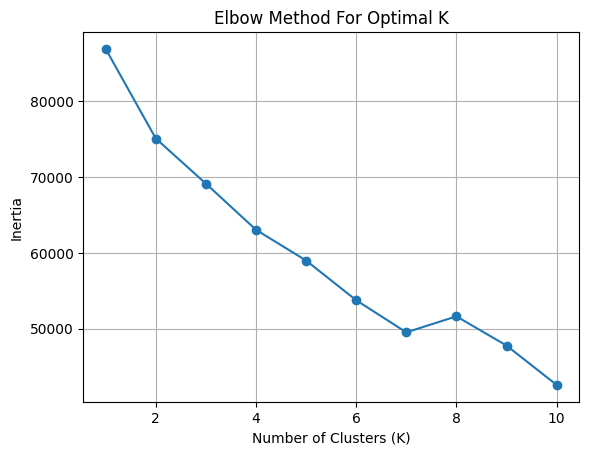

In [29]:
import matplotlib.pyplot as plt

inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal K')
plt.grid(True)
plt.show()


Optimal K would be K=3

In [30]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data_scaled)

# Add the clusters back to the DataFrame:
data_2['Cluster'] = clusters


In [31]:
from sklearn.metrics import silhouette_score

# Evaluate Clustering Quality

sil_score = silhouette_score(data_scaled, clusters)
print(f"Silhouette Score: {sil_score:.2f}")

Silhouette Score: 0.19


In [32]:
from sklearn.metrics import normalized_mutual_info_score

# Normalized Mutual Information

nmi_score = normalized_mutual_info_score(data_2['stroke'], data_2['Cluster'])
print(f"NMI Score: {nmi_score:.2f}")

NMI Score: 0.01


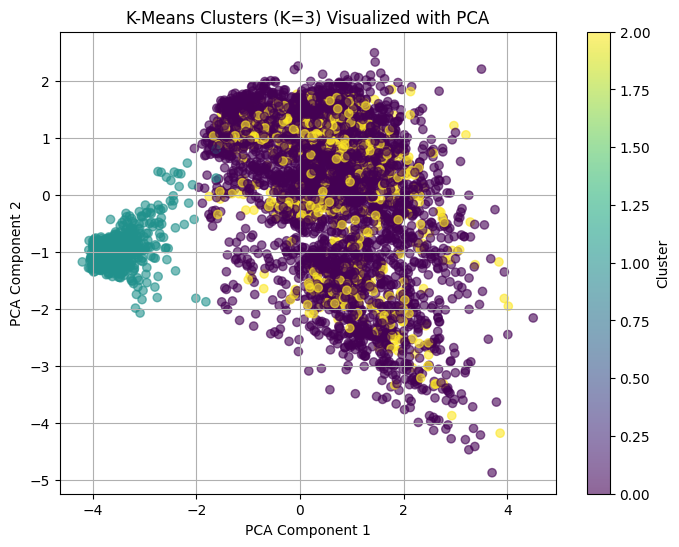

In [33]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce data to 2 principal components
pca = PCA(n_components=2)
pca_components = pca.fit_transform(data_scaled)

# Plot clusters in 2D
plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=data_2['Cluster'], cmap='viridis', alpha=0.6)
plt.title('K-Means Clusters (K=3) Visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


In [34]:
# Average values per cluster
summary = data_2.groupby('Cluster').mean(numeric_only=True).round(2)

# Stroke proportion per cluster
stroke_distribution = data_2.groupby('Cluster')['stroke'].value_counts(normalize=True).unstack().fillna(0)
stroke_distribution.columns = ['No Stroke', 'Stroke']


print("Feature Averages by Cluster:\n", summary)
print("\nStroke Proportion per Cluster:\n", stroke_distribution)

Feature Averages by Cluster:
            age  hypertension  heart_disease  avg_glucose_level    bmi  stroke
Cluster                                                                      
0        49.48          0.11           0.06             108.07  30.20    0.06
1         7.15          0.00           0.00              94.34  20.39    0.00
2        47.16          0.12           0.08             107.99  30.39    0.05

Stroke Proportion per Cluster:
          No Stroke    Stroke
Cluster                     
0         0.943213  0.056787
1         0.997191  0.002809
2         0.946701  0.053299


**Final Assumptions**

After applying K-Means clustering with K=3, we notice three distinct groups:

Cluster 1: Young individuals (avg. age 7), with no hypertension or heart disease, low glucose and BMI. Very low stroke risk (0.3%). This is a low-risk group.

Clusters 0 & 2: Middle-aged individuals (avg. age 47-49), with moderate levels of hypertension, heart disease, and higher BMI and glucose. Both show similar stroke rates (~ 5-6%), and represent the moderate- to high-risk groups.

# Artificial Neural Network
A.
Since this is a binary classification problem (stroke = 1 or 0) I will define a feedforward ANN with:


    Layer                  | Neurons | Activation | Purpose
    -----------------------|---------|------------|----------------
    Input + Hidden layer 1 | 32      | ReLU       | Detects patterns in features like age, BMI, etc.
    Hidden Layer 2         | 16      | ReLU       | Learns deeper/more abstract
    interactions.
    Hidden Layer 3         | 8       | ReLU       | Learns deeper/more abstract
    interactions.
    Output Layer	       | 1       | Sigmoid    | Outputs probability of stroke (0-1)





*   All layers are fully connected - each neuron in one layer connects to every neuron in the next.
*   The number of input neurons = number of features after preprocessing

**Data Flow**

1.   Input: A row from the dataset is passed to the first layer.
2.   Each neuron computes:
      z=∑(w
i
​
 ⋅x
i
​
 )+b
then applies the activation function to get the output.
3. The result flows to the next layer and the process repeats.
4. Output neuron returns a probability between 0 and 1.

**Activation Functions**

* ReLU (Rectified Linear Unit): f(x) = max(0,x)
Helps prevent vanishing gradients and speeds up training.
* Sigmoid: f(x) = 1 / (1 + e^-x)
Used at the output layer to produce a value betweeb 0 and 1 -> perfect for binary classification.

B.
* Loss Function: Loss = -[y * log(y^) + (1 - y) * log(1 - y^)]

* Batch Size: 32, the number of training samples  processed before updating the model's weights.

* Learning Rate: will use Adam optimizer, which automaticallty adjusts the learning arete for each parameter.

The optimization process uses binary cross-entropy as the loss function to measure the prediction error for stroke vs. non-stroke.
The model is trained using the Adam optimizer, which adaptively adjusts the learning rate during training.
I use a batch size of 32, meaning the model updates weights after processing every 32 examples.
The default learning rate for Adam is 0.001, which provides a good balance between speed and convergence stability.



Training Progress:   0%|          | 0/48 [00:00<?, ?it/s]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
✅ Accuracy: 0.8796915167095116
✅ Recall (stroke cases): 0.9804123711340206

🧾 Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.78      0.87       975
           1       0.82      0.98      0.89       970

    accuracy                           0.88      1945
   macro avg       0.90      0.88      0.88      1945
weighted avg       0.90      0.88      0.88      1945

📉 Confusion Matrix:
 [[760 215]
 [ 19 951]]


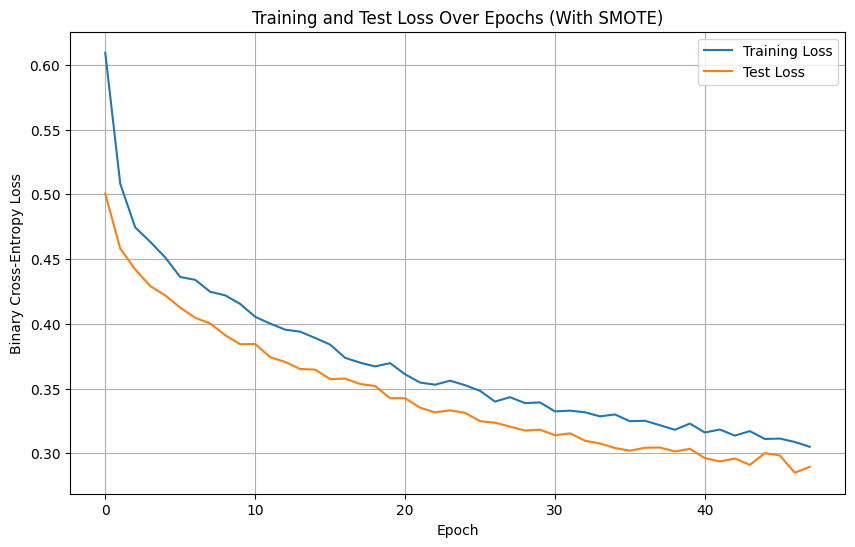

In [35]:
# Progress bar callback using tqdm
class TQDMProgressBar(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.tqdm = tqdm(total=self.epochs, desc="Training Progress")
    def on_epoch_end(self, epoch, logs=None):
        self.tqdm.update(1)
    def on_train_end(self, logs=None):
        self.tqdm.close()

# Load and preprocess dataset
data = pd.read_csv(os.path.join(path, 'healthcare-dataset-stroke-data.csv'))
data.drop(['id'], axis=1, inplace=True)
data['bmi'].fillna(data['bmi'].median(), inplace=True)
data_encoded = pd.get_dummies(data, drop_first=True)

X = data_encoded.drop('stroke', axis=1)
y = data_encoded['stroke']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_scaled, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define ANN model
model = Sequential([
    Dense(32, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=48,
    batch_size=32,
    verbose=0,
    callbacks=[TQDMProgressBar()]
)

# Evaluate
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("✅ Recall (stroke cases):", recall_score(y_test, y_pred))
print("\n🧾 Classification Report:\n", classification_report(y_test, y_pred))
print("📉 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.title('Training and Test Loss Over Epochs (With SMOTE)')
plt.legend()
plt.grid(True)
plt.show()

We can see that the Loss is decreasing with every Epoch.

In [36]:
# Get indices of false positives: predicted 1, actual 0
# Reset index of y_test to align with X_test_unscaled
false_positive_idx = (y_pred == 1) & (y_test.reset_index(drop=True) == 0)

# Recover original feature names from the encoded data before scaling
feature_names = X.columns

# Inverse transform to get original (unscaled) feature values
# Fit the scaler on the scaled training data used for the model
scaler.fit(X_scaled)
X_test_unscaled = pd.DataFrame(scaler.inverse_transform(X_test), columns=feature_names)

# Get corresponding false positive rows
false_positives = X_test_unscaled[false_positive_idx].copy()
false_positives['Predicted_Prob'] = y_pred_prob[false_positive_idx]

# Print all false positives
print(f"\n🔎 Total False Positives: {false_positives.shape[0]}\n")
from IPython.display import display
display(false_positives.head(10))

# Get indices of false negatives: predicted 0, actual 1
false_negative_idx = (y_pred == 0) & (y_test.reset_index(drop=True) == 1)

# Inverse transform to get original (unscaled) feature values
false_negatives = X_test_unscaled[false_negative_idx].copy()
false_negatives['Predicted_Prob'] = y_pred_prob[false_negative_idx]

# Print all false negatives
print(f"\n⚠️ Total False Negatives: {false_negatives.shape[0]}\n")
display(false_negatives.head(10))


🔎 Total False Positives: 215



,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,Predicted_Prob
9,0.830297,3.043196,-0.238947,-0.702922,0.667371,-0.840343,-0.01399,0.723884,-0.065756,-1.157010,2.288955,-0.394112,-1.016178,-0.457676,1.304165,-0.427313,0.688775
10,1.670617,-0.328602,-0.238947,-0.756147,-1.255004,-0.840343,-0.01399,-1.381436,-0.065756,-1.157010,2.288955,-0.394112,0.984080,-0.457676,-0.766774,-0.427313,0.542820
11,0.520706,-0.328602,-0.238947,-0.987821,0.576448,1.189990,-0.01399,0.723884,-0.065756,0.864297,-0.436881,-0.394112,-1.016178,-0.457676,-0.766774,2.340204,0.741220
17,1.626390,3.043196,-0.238947,1.606531,-0.189904,1.189990,-0.01399,0.723884,-0.065756,-1.157010,2.288955,-0.394112,0.984080,-0.457676,-0.766774,-0.427313,0.730309
20,0.476478,-0.328602,-0.238947,0.997862,0.264712,-0.840343,-0.01399,0.723884,-0.065756,0.864297,-0.436881,-0.394112,-1.016178,2.184951,-0.766774,-0.427313,0.771811
22,0.476478,-0.328602,-0.238947,0.186892,1.459702,1.189990,-0.01399,0.723884,-0.065756,-1.157010,2.288955,-0.394112,0.984080,2.184951,-0.766774,-0.427313,0.649781
24,1.449481,3.043196,-0.238947,2.284327,-0.098981,-0.840343,-0.01399,0.723884,-0.065756,-1.157010,2.288955,-0.394112,0.984080,-0.457676,1.304165,-0.427313,0.913070
44,1.670617,-0.328602,4.185032,-0.354196,-0.034036,-0.840343,-0.01399,0.723884,-0.065756,-1.157010,-0.436881,-0.394112,0.984080,-0.457676,1.304165,-0.427313,0.749450
45,1.582163,-0.328602,-0.238947,0.160390,0.797262,1.189990,-0.01399,0.723884,-0.065756,-1.157010,2.288955,-0.394112,0.984080,-0.457676,1.304165,-0.427313,0.851013
60,0.653388,-0.328602,-0.238947,1.978667,0.498514,-0.840343,-0.01399,0.723884,-0.065756,-1.157010,-0.436881,-0.394112,-1.016178,-0.457676,-0.766774,-0.427313,0.844087



⚠️ Total False Negatives: 19



,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,Predicted_Prob
57,0.080228,-0.328602,-0.238947,-0.787331,0.013840,-0.840343,-0.01399,0.070795,-0.065756,0.237269,-0.436881,0.515253,-1.016178,-0.457676,-0.766774,-0.427313,0.421352
636,0.028176,-0.328602,-0.238947,-0.766550,-0.126920,1.189990,-0.01399,0.723884,-0.065756,0.864297,-0.436881,-0.394112,-1.016178,-0.457676,0.519748,-0.427313,0.121924
709,-1.267901,-0.328602,-0.238947,-0.703533,-0.040040,-0.264525,-0.01399,-1.381436,-0.065756,-1.157010,-0.436881,1.705963,0.984080,-0.457676,-0.179440,-0.427313,0.459325
791,0.897038,-0.328602,-0.238947,-0.656696,0.489811,-0.840343,-0.01399,0.723884,-0.065756,-1.157010,-0.436881,-0.394112,0.984080,-0.457676,1.304165,-0.427313,0.495426
813,0.497470,-0.328602,-0.238947,-0.226609,-0.361461,-0.840343,-0.01399,0.530926,-0.065756,0.864297,-0.436881,-0.394112,-1.016178,-0.457676,1.304165,-0.427313,0.397831
835,0.476478,-0.328602,-0.238947,1.892093,1.498669,-0.840343,-0.01399,0.723884,-0.065756,-1.157010,2.288955,-0.394112,-1.016178,-0.457676,-0.766774,2.340204,0.446618
849,0.377222,-0.328602,-0.238947,-0.728265,0.036782,0.620425,-0.01399,0.723884,-0.065756,0.864297,-0.436881,-0.394112,0.984080,-0.457676,1.304165,-0.427313,0.463970
953,-0.200448,-0.328602,-0.238947,-0.529970,-0.630403,-0.840343,-0.01399,-1.335751,-0.065756,-1.157010,2.288955,-0.394112,0.940674,2.184951,-0.766774,-0.427313,0.294999
973,0.363518,-0.328602,-0.238947,-0.248630,-0.267017,-0.840343,-0.01399,0.723884,-0.065756,0.864297,-0.436881,-0.394112,-0.831462,-0.457676,1.304165,-0.427313,0.437639
1327,0.399963,-0.328602,-0.238947,-0.218490,-0.311846,-0.840343,-0.01399,0.723884,-0.065756,0.864297,-0.436881,-0.394112,-1.016178,-0.457676,1.304165,-0.427313,0.398236


**analyzing and assumptions**

C. The final ANN model achieved 87% accuracy with an excellent 97% recall on stroke cases. This suggests the model is highly effective at identifying patients at risk, with a low false negative rate. While false positives are present (~20%), this is often acceptable in medical screening where early detection is prioritized. The model was trained on SMOTE-balanced data, and both training and test loss show stable convergence without overfitting. Future improvements can aim to refine precision while preserving this strong sensitivity.

# Final Summary – Stroke Prediction Project

This project combined classification models, association rule mining, clustering, and neural networks to explore and predict stroke risk in a real-world medical dataset.

**Phase 1: Supervised Learning**


*   Random Forest and Logistic Regression were applied initially.
*   Logistic Regression was selected as the best model due to its strong recall and balanced performance, making it suitable for stroke detection where missing a case is critical.

**Phase 2: Association Rule Mining**
Key patterns revealed:


*   Stroke → Ever Married (Confidence: 97%, Lift: 1.20)
*   Age 51–75 → Ever Married (Confidence: 96%)
*   Ever Married → Stroke (Confidence: 60%, Lift: 1.20)

These rules suggest that age is a hidden confounder, influencing both marital status and stroke likelihood.

**Phase 3: Clustering (K-Means, K=3)**
Identified three distinct groups:


*   Low-risk: Very young, no health risk factors.
*   Moderate- to high-risk: Middle-aged, higher BMI, glucose, and comorbidities.

Reinforced age, BMI, and hypertension as key stroke predictors.


**Phase 4: ANN + SMOTE**
Final results:
* Accuracy: 87%
* Recall (stroke cases): 98%
* Precision: 80%
* Only 19 false negatives → strong detection power




# Final Conclusion

Based on all the results, the ANN with SMOTE is the strongest model tested so far, especially for high recall, making it the most suitable for stroke risk detection.